This script offers a preliminary evaluation of a variant of the motif graph learning algorithm that considers the observations follow a GMRF whose precision matrix is given by a polynomial of the GSO.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

from sklearn.covariance import graphical_lasso
import src.utils as utils
import spectral_nti as snti

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)

PATH = './results/gmrf_st/'

## Auxiliary functions

In [2]:
def est_graph(id, models, MM, L, K, iters, verb=False):
    # X = utils.create_signals(L, MM[-1])
    X = utils.create_GMRF_st_signals(L, K, MM[-1])

    N = X.shape[0]
    A_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i, M in enumerate(MM):
        C_hat = X[:,:M]@X[:,:M].T/M

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()

            if model['name'] == 'GLasso':
                _, L_hat = graphical_lasso(C_hat, model['alpha'], max_iter=iters)
            elif model['St']:
                L_hat, _ = snti.MGL_Stationary_GMRF(C_hat, model['gs'], model['bounds'], 
                                                    model['cs'], model['regs'], max_iters=iters,
                                                    verbose=verb, epsilon=1e-5)
            else:
                L_hat, _ = snti.MGL(C_hat, model['gs'], model['bounds'], 
                                    model['cs'], model['regs'], max_iters=iters,
                                    verbose=verb, epsilon=1e-5)

            lamd_hat[:,j,i], _ = np.linalg.eigh(L_hat) 
            A_hat[:,:,j,i] = np.diag(np.diag(L_hat)) - L_hat
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {}-{} - Time(sec): {:.3}'.format(id, M, model['name'],  model['St'], t))
    return A_hat, lamd_hat


def est_errs(A, lamd, A_hat, lams_hat, sq_err=True):
    norm_A = np.linalg.norm(A, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)

    err_lamb = np.zeros(lams_hat.shape[1:])
    err_A = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                if np.all((A_hat[:,:,j,i,k] == 0)):
                    norm_A_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_A_hat = np.linalg.norm(A_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                A_hat_norm = A_hat[:,:,j,i,k]/norm_A_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_A[j,i,k] = np.linalg.norm(A/norm_A-A_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_A[j,i,k] = err_A[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_A, err_lamb


def plot_err(MM, models, err, ylab, semlogy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if semlogy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                     linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Number of samples')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


def print_err(MM, models, err):
    mean_err = np.mean(err, 2)
    std = np.std(err, 2)
    for i, M in enumerate(MM):
        print('M:', M)
        for j, model in enumerate(models):
            print('\t{}: mean err: {:.6f} - std: {:.6f}'.
                   format(model['name'], mean_err[j,i], std[j,i]))

## Create graphs

Norm of A: 11.313708498984761
Norm of lambdas: 31.527765540868902


Text(0.5, 1.0, 'True Lambdas, N: 20')

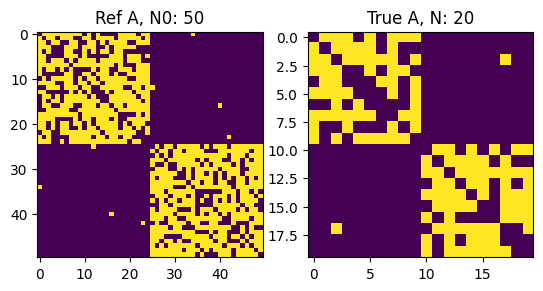

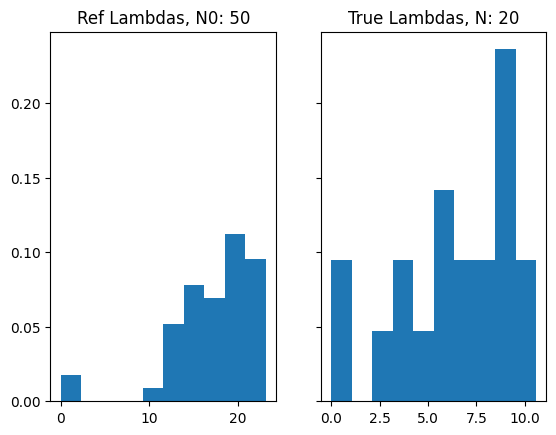

In [3]:
# G params
p = .7
q = .01
block_sizes0 = [25, 25]
block_sizes = [10, 10]

# Ref graph
A0 = nx.to_numpy_array(nx.random_partition_graph(block_sizes0, p, q))
L0 = np.diag(np.sum(A0, 0)) - A0
lambdas0, _ = np.linalg.eigh(L0)
N0 = lambdas0.shape[0]

# Target graph

A = nx.to_numpy_array(nx.random_partition_graph(block_sizes, p, q))
L = np.diag(np.sum(A, 0)) - A
lambdas, V = np.linalg.eigh(L)
N = lambdas.shape[0]

norm_A = np.linalg.norm(A,'fro')
norm_lamb = np.linalg.norm(lambdas)

print('Norm of A:', norm_A)
print('Norm of lambdas:', norm_lamb)

# Plot graphs and spectrum distribution
plt.figure()
plt.subplot(1,2,1)
plt.imshow(A0)
plt.title('Ref A, N0: ' + str(N0))
plt.subplot(1,2,2)
plt.imshow(A)
plt.title('True A, N: ' + str(N))
    
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True)
axs[0].set_title('Ref Lambdas, N0: ' + str(N0))
axs[1].hist(lambdas, density=True)
axs[1].set_title('True Lambdas, N: ' + str(N))

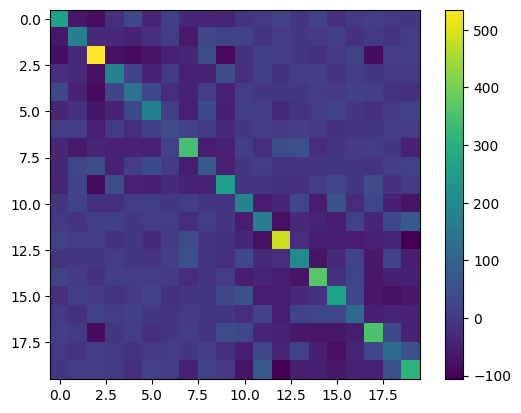

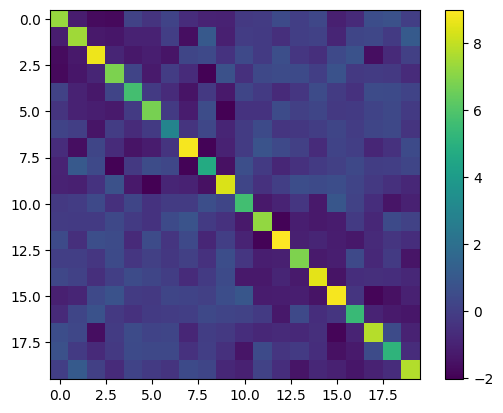

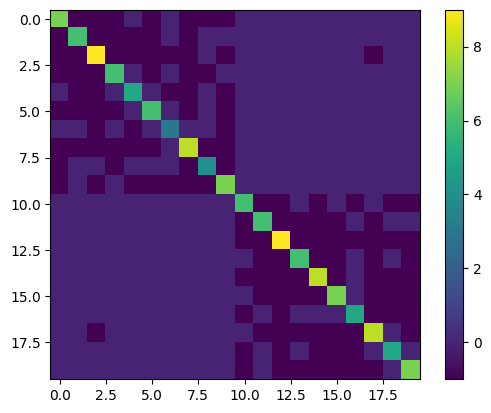

In [4]:
M = 300
K = 4
X = utils.create_GMRF_st_signals(L, K, M)
C_st = X[:,:M]@X[:,:M].T/M

X = utils.create_signals(L, M)
C = X[:,:M]@X[:,:M].T/M

plt.figure()
plt.imshow(np.linalg.pinv(C_st))
plt.colorbar()

plt.figure()
plt.imshow(np.linalg.pinv(C))
plt.colorbar()

plt.figure()
plt.imshow(L)
plt.colorbar()

## Compare contraints

In [5]:
n_covs = 10  #100
#MM = np.arange(300, 1501, 100)
MM = [100, 300, 500]
K = 4
iters = 50

GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum(cp.sqrt(a))/b,
    lambda a, b : cp.sum((.5*a-.75)**2)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b : cp.sum(lamd/cp.sqrt(lamd_t))/(2*b),
    lambda lamd, lamd_t, b: 1/b*(0.75-.5*lamd_t).T@lamd,
]

# deltas = [.04, .27, .003, .02, 0.05]
deltas = [11, 257, .07, 1.9, 56]
cs, err_cs = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

models = [
    {'St': False, 'name': 'GLasso', 'alpha': 0.05, 'fmt': '^:'},

    
    # {'St': True, 'name': 'Unc', 'gs': [], 'bounds': [], 'cs': [], 'fmt': '1-',
    #  'regs': {'alpha': .01, 'beta': 1.75, 'gamma': 0, 'eta': 1, 'inc_eta': 1.1,
    #            'deltas': []}},
   
    {'St': True, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1, 'eta': 1, 'inc_eta': 1.1,
              'deltas': deltas[0]}},

    {'St': True, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o-',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 500, 'eta': .05, 'inc_eta': 1.1,
              'deltas': deltas[1]}},

    # {'St': True, 'name': 'Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'cs': cs[2], 'fmt': 'x-',
    #  'regs': {'alpha': .001, 'beta': .4, 'gamma': 100, 'eta': 1, 'inc_eta': 1.1,
    #           'deltas': deltas[2]}},

    # {'St': True, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's-',
    #  'regs': {'alpha': 0, 'beta': 1, 'gamma': 10, 'eta': .1, 'inc_eta': 1.1, 
    #           'deltas': deltas[4]}},

    # Non-st
    # {'St': False, 'name': 'Unc', 'gs': [], 'bounds': [], 'cs': [], 'fmt': '1--',
    #  'regs': {'alpha': .01, 'beta': 1.75, 'gamma': 0,'deltas': []}},

    {'St': False, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1, 'deltas': deltas[0]}},

    {'St': False, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o--',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 500, 'deltas': deltas[1]}},

    # {'St': False, 'name': 'Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'cs': cs[2], 'fmt': 'x--',
    #  'regs': {'alpha': .001, 'beta': .4, 'gamma': 100, 'deltas': deltas[2]}},

    # {'St': False, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's--',
    #  'regs': {'alpha': 0, 'beta': 1, 'gamma': 10, 'deltas': deltas[4]}},

    # {'St': False, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's--',
    #  'regs': {'alpha': 0, 'beta': 1, 'gamma': 5000, 'eta': 1, 'inc_eta': 1.1, 
    #           'deltas': deltas[4]}},
]

	c-0: c: 6.400	c0: 17.120	err: -10.720000	err norm: -0.626168
	c-1: c: 49.700	c0: 315.600	err: -265.900000	err norm: -0.842522
	c-2: c: 0.049	c0: 0.015	err: 0.034295	err norm: 2.294605
	c-3: c: 2.386	c0: 4.046	err: -1.659781	err norm: -0.410272
	c-4: c: 8.159	c0: 66.611	err: -58.451875	err norm: -0.877508


In [6]:
# Estimate graph
verbose = False

total_t = time.time()
As_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, L, K, iters, verbose) for i in range(n_covs))
for i, resp in enumerate(resps):
    As_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 128


/home/srey/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8479056936193672e-05, tolerance: 1.5116886505847555e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9053120129250996e-05, tolerance: 3.3855849452138235e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047383563215008806, tolerance: 0.00045677446536714647
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/.local/lib/python3.8/site-packages/sklearn/c

Cov-2, M-100: Model: GLasso-False - Time(sec): 0.00482
Cov-8, M-100: Model: GLasso-False - Time(sec): 0.0117
Cov-0, M-100: Model: GLasso-False - Time(sec): 0.0287
Cov-3, M-100: Model: GLasso-False - Time(sec): 0.0571
Cov-6, M-100: Model: GLasso-False - Time(sec): 0.00931
Cov-5, M-100: Model: GLasso-False - Time(sec): 0.0375
Cov-7, M-100: Model: GLasso-False - Time(sec): 0.0634
Cov-4, M-100: Model: GLasso-False - Time(sec): 0.0907


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: 

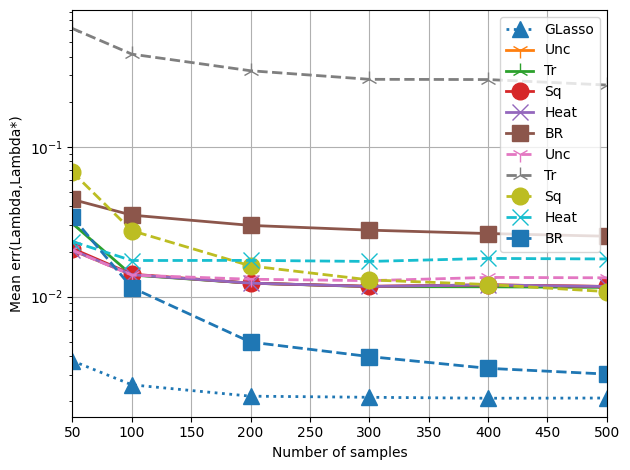

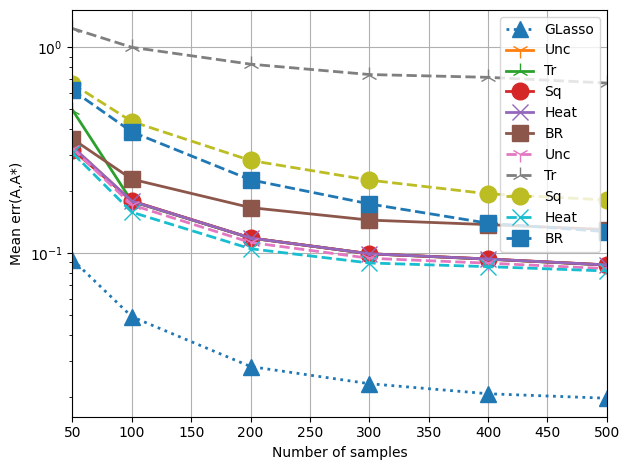

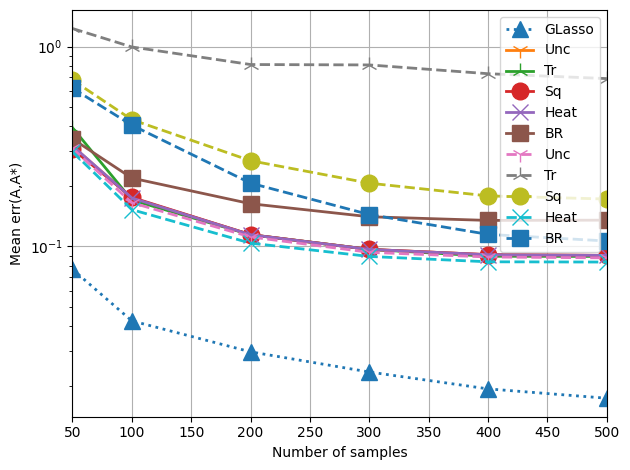

In [ ]:
# err_lamb = est_err(lamds_hat, lambdas)

err_A, err_lamd = est_errs(A, lambdas, As_hat, lamds_hat, sq_err=True)

mean_err_lam = np.mean(err_lamd, 2)
plot_err(MM, models, mean_err_lam, 'Mean err(Lambda,Lambda*)')
plt.savefig('tmp/err_lamb.png')

mean_err_A = np.mean(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A.png')

mean_err_A = np.median(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A.png')



In [ ]:
# Save np data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': model['regs']}
#                 for model in models]
# data = {
#     'A': A,
#     'lambdas': lambdas,
#     'lambdas0': lambdas0,
#     'As_hat': As_hat,
#     'lamds_hat': lamds_hat,
#     'MM': MM,
#     'models': models_aux
# }
# file = 'constraints_{}covs_{}iters'.format(n_covs, iters)
# np.save('results/constraints/' + file, data)

# # Save spectrum
# N = 200
# N0 = 150

# models_hist = [{'name': 'True spectrum'}] + models

# all_lambdas = np.concatenate((lambdas.reshape([N, 1]),
#                               np.squeeze(lamds_hat[:,:,idx,0])), axis=1)

# fname = PATH + 'constraints_hists.csv'
# utils.error_to_csv(fname, models_hist, [], all_lambdas)

# fname = PATH + 'constraints_hists_ref.csv'
# models_hist_ref = [{'name': 'Ref spectrum'}]
# utils.error_to_csv(fname, models_hist_ref, [], lambdas0.reshape([N0, 1]))

In [ ]:
# Save data as csv
# fname = PATH + 'constraints.csv'
# utils.error_to_csv(fname, models, MM, mean_err_lam)


In [ ]:
# %matplotlib qt

# # Load data
# file = 'results/constraints/constraints_100covs_200iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# A = data['A']
# lambdas = data['lambdas']
# lambdas0 = data['lambdas0']
# As_hat = data['As_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']